In [42]:
!pip install yfinance ta gspread oauth2client scikit-learn schedule python-telegram-bot --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.1/717.1 kB 18.7 MB/s eta 0:00:00


## Data Ingestion Alpha Vantage ( API)

Fetch historical data for at least 3 NIFTY 50 stocks using the FMP API.

In [ ]:
import requests
import pandas as pd
from google.colab import userdata

# Get Alpha Vantage API key - User will put it directly in the code
ALPHA_VANTAGE_API_KEY = "Your Alpha Vantage API key" # Replace with your actual API key

def fetch_alpha_vantage_data(symbol, api_key):
    """
    Fetches daily stock data for a given symbol using Alpha Vantage API.

    Args:
        symbol: The stock symbol.
        api_key: Your Alpha Vantage API key.

    Returns:
        pandas DataFrame with daily stock data, or None if fetching fails.
    """
    if not api_key or api_key == "YOUR_ALPHA_VANTAGE_API_KEY":
        print("Alpha Vantage API key is not provided or is the placeholder.")
        return None

    base_url = "https://www.alphavantage.co/query?"
    function = "TIME_SERIES_DAILY_ADJUSTED"
    outputsize = "full" # or "compact" for the last 100 data points

    params = {
        "function": function,
        "symbol": symbol,
        "outputsize": outputsize,
        "apikey": api_key
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if "Time Series (Daily)" in data:
            df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
            df.index = pd.to_datetime(df.index)
            df = df.astype(float)
            # Rename columns for consistency
            df.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend amount', 'split coefficient']
            # Reverse the order to have the oldest data first
            df = df.iloc[::-1]
            return df[['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume']] # Return relevant columns
        else:
            print(f"Error fetching data for {symbol}: No 'Time Series (Daily)' found in response.")
            print(data)
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while processing data for {symbol}: {e}")
        return None

# Select NIFTY 50 stock symbols (replace with your desired symbols)
nifty_50_symbols = ["RELIANCE.BSE", "TCS.BSE", "INFY.BSE"] # Example BSE symbols for Alpha Vantage

stock_data_av = {}
if ALPHA_VANTAGE_API_KEY and ALPHA_VANTAGE_API_KEY != "YOUR_ALPHA_VANTAGE_API_KEY":
    for symbol in nifty_50_symbols:
        print(f"Fetching data for {symbol} using Alpha Vantage...")
        data = fetch_alpha_vantage_data(symbol, ALPHA_VANTAGE_API_KEY)
        if data is not None:
            stock_data_av[symbol] = data
            print(f"Successfully fetched data for {symbol}")
            display(data.head())
else:
    print("Skipping Alpha Vantage data fetching as API key is not available or is the placeholder.")

# You can now use the 'stock_data_av' dictionary for further analysis

Fetching data for RELIANCE.BSE using Alpha Vantage...
Error fetching data for RELIANCE.BSE: No 'Time Series (Daily)' found in response.
{'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}
Fetching data for TCS.BSE using Alpha Vantage...
Error fetching data for TCS.BSE: No 'Time Series (Daily)' found in response.
{'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}
Fetching data for INFY.BSE using Alpha Vantage...
Error fetching data for INFY.BSE: No 'Time Series (Daily)' found in response.
{'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all 

## Data Ingestion (FMP API)

Fetch historical data for at least 3 NIFTY 50 stocks using the FMP API.

In [ ]:
import requests
import pandas as pd

# Get FMP API key - Replace with your actual API key
FMP_API_KEY = "Your Actual FMP API key" # Replace with your actual API key

def fetch_fmp_data(symbol, api_key, period='daily', start_date=None, end_date=None):
    """
    Fetches historical stock data for a given symbol using FMP API.

    Args:
        symbol: The stock symbol (e.g., RELIANCE.NS for NSE, RELIANCE.BO for BSE).
        api_key: Your FMP API key.
        period: Data period ('daily', 'hourly', etc.). Default is 'daily'.
        start_date: Start date for historical data (YYYY-MM-DD).
        end_date: End date for historical data (YYYY-MM-DD).

    Returns:
        pandas DataFrame with historical stock data, or None if fetching fails.
    """
    if not api_key or api_key == "YOUR_FMP_API_KEY":
        print("FMP API key is not provided or is the placeholder.")
        return None

    base_url = f"https://financialmodelingprep.com/api/v3/historical-{period}-price/{symbol}"

    params = {
        "apikey": api_key
    }
    if start_date:
        params["from"] = start_date
    if end_date:
        params["to"] = end_date


    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if isinstance(data, list): # FMP returns a list of dictionaries for historical data
            df = pd.DataFrame(data)
            if not df.empty:
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
                df.sort_index(inplace=True) # Sort by date
                return df[['open', 'high', 'low', 'close', 'volume']] # Return relevant columns
            else:
                 print(f"Error fetching data for {symbol}: Empty dataframe received.")
                 return None
        elif isinstance(data, dict) and "Error Message" in data:
             print(f"Error fetching data for {symbol}: {data['Error Message']}")
             return None
        else:
            print(f"Error fetching data for {symbol}: Unexpected response format.")
            print(data)
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while processing data for {symbol}: {e}")
        return None

# Select NIFTY 50 stock symbols (replace with your desired symbols and exchange suffix)
# Use .NS for NSE and .BO for BSE
nifty_50_symbols_fmp = ["RELIANCE.NS", "TCS.NS", "INFY.NS"]

# Define the date range for the last 6 months
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = (pd.Timestamp.now() - pd.DateOffset(months=6)).strftime('%Y-%m-%d')

stock_data_fmp = {}
if FMP_API_KEY and FMP_API_KEY != "YOUR_FMP_API_KEY":
    for symbol in nifty_50_symbols_fmp:
        print(f"Fetching data for {symbol} using FMP...")
        data = fetch_fmp_data(symbol, FMP_API_KEY, start_date=start_date, end_date=end_date)
        if data is not None:
            stock_data_fmp[symbol] = data
            print(f"Successfully fetched data for {symbol}")
            display(data.head())
else:
    print("Skipping FMP data fetching as API key is not available or is the placeholder.")

# You can now use the 'stock_data_fmp' dictionary for further analysis

Fetching data for RELIANCE.NS using FMP...
Error fetching data for RELIANCE.NS: 403 Client Error: Forbidden for url: https://financialmodelingprep.com/api/v3/historical-daily-price/RELIANCE.NS?apikey=ImYHk2VQqYDjkCmQn3HYwgxE4x5VgniF&from=2025-02-09&to=2025-08-09
Fetching data for TCS.NS using FMP...
Error fetching data for TCS.NS: 403 Client Error: Forbidden for url: https://financialmodelingprep.com/api/v3/historical-daily-price/TCS.NS?apikey=ImYHk2VQqYDjkCmQn3HYwgxE4x5VgniF&from=2025-02-09&to=2025-08-09
Fetching data for INFY.NS using FMP...
Error fetching data for INFY.NS: 403 Client Error: Forbidden for url: https://financialmodelingprep.com/api/v3/historical-daily-price/INFY.NS?apikey=ImYHk2VQqYDjkCmQn3HYwgxE4x5VgniF&from=2025-02-09&to=2025-08-09


## data loading




for 6 stocks over last 10 years


In [43]:
import yfinance as yf
import pandas as pd

# Select 6 NIFTY 50 stock symbols
nifty_50_symbols = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS",
    "HDFCBANK.NS", "ITC.NS", "SBIN.NS"
]

# Define the date range for the last 10 years (120 months)
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = (pd.Timestamp.now() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')

stock_data = {}
for symbol in nifty_50_symbols:
    try:
        # Fetch historical data
        data = yf.download(symbol, start=start_date, end=end_date)
        data.reset_index(inplace=True)
        data.columns = [col if not isinstance(col, tuple) else col[0] for col in data.columns]
        if "Adj Close" in data.columns and "Close" not in data.columns:
            data.rename(columns={"Adj Close": "Close"}, inplace=True)


        # Flatten MultiIndex columns (if any)
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = ['_'.join(col).strip() for col in data.columns.values]

        # Reset index to make 'Date' a column
        data.reset_index(inplace=True)

        stock_data[symbol] = data
        print(f"✅ Successfully fetched data for {symbol} ({len(data)} rows)")
    except Exception as e:
        print(f"❌ Error fetching data for {symbol}: {e}")

# Save all to a single Excel file (one sheet per stock)
with pd.ExcelWriter("nifty_data.xlsx") as writer:
    for symbol, df in stock_data.items():
        df.to_excel(writer, sheet_name=symbol, index=False)

print("\n📁 Data saved to nifty_data.xlsx — ready for download.")

/tmp/ipython-input-1308208282.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308208282.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308208282.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308208282.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1

✅ Successfully fetched data for RELIANCE.NS (2469 rows)
✅ Successfully fetched data for TCS.NS (2469 rows)
✅ Successfully fetched data for INFY.NS (2469 rows)
✅ Successfully fetched data for HDFCBANK.NS (2469 rows)


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1308208282.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


✅ Successfully fetched data for ITC.NS (2469 rows)
✅ Successfully fetched data for SBIN.NS (2469 rows)

📁 Data saved to nifty_data.xlsx — ready for download.


## Calculate technical indicators




In [44]:
import ta

# Iterate through the stock_data dictionary
for symbol, df in stock_data.items():
    print(f"Calculating technical indicators for {symbol}...")

    # Calculate RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # Calculate SMA20 and SMA50
    df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
    df['SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50)

    # Calculate MACD
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()

    # Calculate ATR
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()

    # Handle NaN values created by indicator calculations (fill with 0)
    df.fillna(0, inplace=True)

    stock_data[symbol] = df # Update the dictionary with the modified DataFrame
    print(f"Finished calculating indicators for {symbol}. DataFrame shape: {df.shape}")


# Display the head of one of the modified DataFrames to verify
if stock_data:
    first_symbol = list(stock_data.keys())[0]
    print(f"\nDisplaying head of {first_symbol} with indicators:")
    display(stock_data[first_symbol].head())
else:
    print("\nNo stock data available to display.")

Calculating technical indicators for RELIANCE.NS...
Finished calculating indicators for RELIANCE.NS. DataFrame shape: (2469, 13)
Calculating technical indicators for TCS.NS...
Finished calculating indicators for TCS.NS. DataFrame shape: (2469, 13)
Calculating technical indicators for INFY.NS...
Finished calculating indicators for INFY.NS. DataFrame shape: (2469, 13)
Calculating technical indicators for HDFCBANK.NS...
Finished calculating indicators for HDFCBANK.NS. DataFrame shape: (2469, 13)
Calculating technical indicators for ITC.NS...
Finished calculating indicators for ITC.NS. DataFrame shape: (2469, 13)
Calculating technical indicators for SBIN.NS...
Finished calculating indicators for SBIN.NS. DataFrame shape: (2469, 13)

Displaying head of RELIANCE.NS with indicators:


,index,Date,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,MACD,MACD_Signal,ATR
0,0,2015-08-10,210.783554,215.112779,209.826335,214.177329,9288894,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2015-08-11,210.152679,211.816928,208.412276,211.240424,8762464,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2015-08-12,205.127289,210.152681,204.616048,209.630563,9650325,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2015-08-13,203.049683,207.531202,202.190358,206.019234,9340350,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2015-08-14,210.359329,211.457951,203.256343,204.550768,12739366,0.0,0.0,0.0,0.0,0.0,0.0


## Generate trading labels



In [45]:
import ta

# Calculate Average Volume (e.g., over 20 periods)
for symbol, df in stock_data.items():
    df['Avg_Volume_20'] = df['Volume'].rolling(window=20).mean()
    stock_data[symbol] = df # Update the dictionary with the modified DataFrame


# Iterate through each DataFrame in the stock_data dictionary
for symbol, df in stock_data.items():
    print(f"Generating trading signals with volume breakout confirmation for {symbol}...")

    # Initialize 'Signal' column with None
    df['Signal'] = None

    # Define a volume breakout threshold (e.g., 1.5 times the average volume)
    volume_threshold = 1.5

    # Implement the 'BUY' signal logic with volume breakout confirmation
    # SMA_20 crosses above SMA_50 AND RSI is below 70 AND Volume > volume_threshold * Avg_Volume_20
    df.loc[(df['SMA_20'].shift(1) <= df['SMA_50'].shift(1)) &
           (df['SMA_20'] > df['SMA_50']) &
           (df['RSI'] < 70) &
           (df['Volume'] > volume_threshold * df['Avg_Volume_20'].shift(1)), 'Signal'] = 'BUY'

    # Implement the 'SELL' signal logic with volume breakout confirmation
    # SMA_20 crosses below SMA_50 AND RSI is above 30 AND Volume > volume_threshold * Avg_Volume_20
    df.loc[(df['SMA_20'].shift(1) >= df['SMA_50'].shift(1)) &
           (df['SMA_20'] < df['SMA_50']) &
           (df['RSI'] > 30) &
           (df['Volume'] > volume_threshold * df['Avg_Volume_20'].shift(1)), 'Signal'] = 'SELL'

    # Update the dictionary with the modified DataFrame
    stock_data[symbol] = df
    print(f"Finished generating signals for {symbol}. DataFrame shape: {df.shape}")

# Display the head of one of the modified DataFrames to verify the Signal column
if stock_data:
    first_symbol = list(stock_data.keys())[0]
    print(f"\nDisplaying head of {first_symbol} with Signal column:")
    display(stock_data[first_symbol].head())
else:
    print("\nNo stock data available to display.")

Generating trading signals with volume breakout confirmation for RELIANCE.NS...
Finished generating signals for RELIANCE.NS. DataFrame shape: (2469, 15)
Generating trading signals with volume breakout confirmation for TCS.NS...
Finished generating signals for TCS.NS. DataFrame shape: (2469, 15)
Generating trading signals with volume breakout confirmation for INFY.NS...
Finished generating signals for INFY.NS. DataFrame shape: (2469, 15)
Generating trading signals with volume breakout confirmation for HDFCBANK.NS...
Finished generating signals for HDFCBANK.NS. DataFrame shape: (2469, 15)
Generating trading signals with volume breakout confirmation for ITC.NS...
Finished generating signals for ITC.NS. DataFrame shape: (2469, 15)
Generating trading signals with volume breakout confirmation for SBIN.NS...
Finished generating signals for SBIN.NS. DataFrame shape: (2469, 15)

Displaying head of RELIANCE.NS with Signal column:


,index,Date,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,MACD,MACD_Signal,ATR,Avg_Volume_20,Signal
0,0,2015-08-10,210.783554,215.112779,209.826335,214.177329,9288894,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None
1,1,2015-08-11,210.152679,211.816928,208.412276,211.240424,8762464,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None
2,2,2015-08-12,205.127289,210.152681,204.616048,209.630563,9650325,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None
3,3,2015-08-13,203.049683,207.531202,202.190358,206.019234,9340350,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None
4,4,2015-08-14,210.359329,211.457951,203.256343,204.550768,12739366,0.0,0.0,0.0,0.0,0.0,0.0,NaN,None


## Prepare data for ml




In [46]:
train_data = {}
test_data = {}

for symbol, df in stock_data.items():
    print(f"Splitting data for {symbol}...")

    # Calculate the index for the 80% split
    split_index = int(len(df) * 0.8)

    # Split the data
    train_df = df.iloc[:split_index].copy()
    test_df = df.iloc[split_index:].copy()

    # Store the split data
    train_data[symbol] = train_df
    test_data[symbol] = test_df

    print(f"Finished splitting data for {symbol}.")
    print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")

# Print shapes for one stock to verify
if train_data and test_data:
    first_symbol = list(train_data.keys())[0]
    print(f"\nVerification: Shapes for {first_symbol}")
    print(f"Train shape: {train_data[first_symbol].shape}")
    print(f"Test shape: {test_data[first_symbol].shape}")
else:
    print("\nNo data available to split.")

Splitting data for RELIANCE.NS...
Finished splitting data for RELIANCE.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)
Splitting data for TCS.NS...
Finished splitting data for TCS.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)
Splitting data for INFY.NS...
Finished splitting data for INFY.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)
Splitting data for HDFCBANK.NS...
Finished splitting data for HDFCBANK.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)
Splitting data for ITC.NS...
Finished splitting data for ITC.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)
Splitting data for SBIN.NS...
Finished splitting data for SBIN.NS.
Train data shape: (1975, 15), Test data shape: (494, 15)

Verification: Shapes for RELIANCE.NS
Train shape: (1975, 15)
Test shape: (494, 15)


## Train machine learning model


Train a classification model (RandomForest or XGBoost) on the training data, addressing class imbalance.


**Reasoning**:
Train a RandomForestClassifier model for each stock in the training data, using class weighting to handle imbalance, and store the trained models.



In [47]:
from sklearn.ensemble import RandomForestClassifier

trained_models = {}

for symbol, df_train in train_data.items():
    print(f"Training model for {symbol}...")

    # Define features (X) and target (y)
    features = ['RSI', 'SMA_20', 'SMA_50', 'MACD', 'MACD_Signal', 'ATR']

    # Drop rows where 'Signal' is None
    df_train_cleaned = df_train.dropna(subset=['Signal']).copy()

    X_train = df_train_cleaned[features]
    y_train = df_train_cleaned['Signal']

    # Check if there are any samples left after dropping NaNs
    if len(X_train) == 0:
        print(f"No valid training samples for {symbol} after dropping None signals. Skipping model training.")
        continue


    # Initialize and train the RandomForestClassifier with class weighting
    # Use try-except to catch potential errors during training
    try:
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)

        # Store the trained model
        trained_models[symbol] = model

        print(f"Finished training model for {symbol}.")
    except ValueError as e:
        print(f"Error training model for {symbol}: {e}")
        print(f"Value counts of y_train for {symbol}: {y_train.value_counts()}")


print("\n✅ All models training process completed. Check logs for any skipped models or errors.")

Training model for RELIANCE.NS...
Finished training model for RELIANCE.NS.
Training model for TCS.NS...
Finished training model for TCS.NS.
Training model for INFY.NS...
Finished training model for INFY.NS.
Training model for HDFCBANK.NS...
Finished training model for HDFCBANK.NS.
Training model for ITC.NS...
Finished training model for ITC.NS.
Training model for SBIN.NS...
Finished training model for SBIN.NS.

✅ All models training process completed. Check logs for any skipped models or errors.


## Evaluate model performance

Evaluate the trained model on the test set using appropriate metrics (Accuracy, Balanced Accuracy, Precision/Recall per class).


In [48]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

# Iterate through the trained models and test data
for symbol in trained_models.keys():
    print(f"\nEvaluating model for {symbol}...")

    # Get the test data for the current stock
    test_df = test_data[symbol].copy() # Use a copy to avoid modifying the original test_data

    # Define features (X) and target (y) for the test set
    features = ['RSI', 'SMA_20', 'SMA_50', 'MACD', 'MACD_Signal', 'ATR']

    # Drop rows where 'Signal' is None from the test set
    test_df_cleaned = test_df.dropna(subset=['Signal']).copy()

    # Check if there are any samples left after dropping NaNs
    if len(test_df_cleaned) == 0:
        print(f"No valid test samples for {symbol} after dropping None signals. Skipping model evaluation.")
        continue

    X_test = test_df_cleaned[features]
    y_test = test_df_cleaned['Signal']


    # Get the trained model
    model = trained_models[symbol]

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print("Classification Report:")
    print(report)

print("\n✅ Model evaluation completed for all stocks.")


Evaluating model for RELIANCE.NS...
No valid test samples for RELIANCE.NS after dropping None signals. Skipping model evaluation.

Evaluating model for TCS.NS...
No valid test samples for TCS.NS after dropping None signals. Skipping model evaluation.

Evaluating model for INFY.NS...
Accuracy: 0.0000
Balanced Accuracy: 0.0000
Classification Report:
              precision    recall  f1-score   support

         BUY       0.00      0.00      0.00       1.0
        SELL       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0


Evaluating model for HDFCBANK.NS...
Accuracy: 1.0000
Balanced Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

         BUY       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
w

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

## Backtest trading strategy

Perform a backtest on the test set using the model's predicted signals to calculate the Profit and Loss (PnL).


In [49]:
import numpy as np

for symbol in trained_models.keys():
    print(f"\nBacktesting trading strategy for {symbol}...")

    # Get the test data for the current stock
    test_df = test_data[symbol].copy() # Use a copy to avoid modifying the original test_data

    # Define features (X) and target (y) for the test set
    features = ['RSI', 'SMA_20', 'SMA_50', 'MACD', 'MACD_Signal', 'ATR']
    X_test = test_df[features]
    y_test = test_df['Signal'] # Actual signals (for comparison if needed, but not used in backtest logic)

    # Get the trained model
    model = trained_models[symbol]

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Initialize backtesting variables
    position = 0  # 0: No position, 1: Long position
    buy_price = 0
    pnl = 0
    trades = [] # Optional: to log trades

    # Iterate through predicted signals and actual closing prices
    for i in range(len(y_pred)):
        signal = y_pred[i]
        current_day_close = test_df['Close'].iloc[i]
        current_date = test_df['Date'].iloc[i]

        # BUY signal logic
        if signal == 'BUY' and position == 0:
            position = 1
            buy_price = current_day_close
            # trades.append({'type': 'BUY', 'date': current_date, 'price': buy_price})
            print(f"Date: {current_date.date()}, BUY Signal! Entry Price: {buy_price:.2f}")

        # SELL signal logic
        elif signal == 'SELL' and position == 1:
            profit = current_day_close - buy_price
            pnl += profit
            position = 0
            buy_price = 0 # Reset buy price
            # trades.append({'type': 'SELL', 'date': current_date, 'price': current_day_close, 'profit': profit})
            print(f"Date: {current_date.date()}, SELL Signal! Exit Price: {current_day_close:.2f}, Trade Profit: {profit:.2f}")

    # Close any open position at the end of the test period
    if position == 1:
        last_close = test_df['Close'].iloc[-1]
        profit = last_close - buy_price
        pnl += profit
        # trades.append({'type': 'SELL (End of Test)', 'date': test_df['Date'].iloc[-1], 'price': last_close, 'profit': profit})
        print(f"End of test period. Closing open position. Final Exit Price: {last_close:.2f}, Trade Profit: {profit:.2f}")


    print(f"\nTotal PnL for {symbol}: {pnl:.2f}")

print("\n✅ Backtesting completed for all stocks.")


Backtesting trading strategy for RELIANCE.NS...
Date: 2023-08-14, BUY Signal! Entry Price: 1279.75
Date: 2023-08-17, SELL Signal! Exit Price: 1260.26, Trade Profit: -19.49
Date: 2023-11-24, BUY Signal! Entry Price: 1192.90
Date: 2023-11-30, SELL Signal! Exit Price: 1184.70, Trade Profit: -8.20
Date: 2023-12-04, BUY Signal! Entry Price: 1206.01
Date: 2023-12-12, SELL Signal! Exit Price: 1207.93, Trade Profit: 1.92
Date: 2023-12-14, BUY Signal! Entry Price: 1227.91
Date: 2024-01-23, SELL Signal! Exit Price: 1324.08, Trade Profit: 96.17
Date: 2024-01-29, BUY Signal! Entry Price: 1443.15
Date: 2024-02-28, SELL Signal! Exit Price: 1450.70, Trade Profit: 7.55
Date: 2024-03-01, BUY Signal! Entry Price: 1487.08
Date: 2024-03-07, SELL Signal! Exit Price: 1473.92, Trade Profit: -13.16
Date: 2024-06-27, BUY Signal! Entry Price: 1525.37
Date: 2024-07-16, SELL Signal! Exit Price: 1570.92, Trade Profit: 45.55
Date: 2024-07-18, BUY Signal! Entry Price: 1581.31
Date: 2024-07-19, SELL Signal! Exit Pri

## Analyze features

Analyze the features used in the model using a correlation heatmap and feature importance methods (SHAP or `feature_importances_`).


Correlation Heatmap of Features:


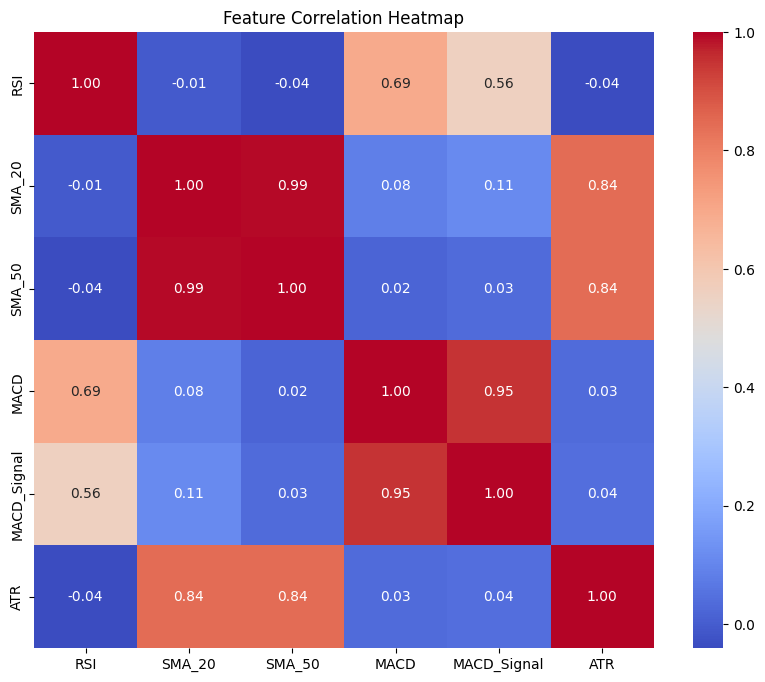


Feature Importances (RELIANCE.NS Model):


,0
RSI,0.325373
MACD_Signal,0.244887
MACD,0.179104
SMA_20,0.104588
SMA_50,0.073521
ATR,0.072526


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Select feature columns from one of the training DataFrames
# We'll use RELIANCE.NS as an example, assuming train_data is available
if 'RELIANCE.NS' in train_data:
    features = ['RSI', 'SMA_20', 'SMA_50', 'MACD', 'MACD_Signal', 'ATR']
    features_df = train_data['RELIANCE.NS'][features]

    # 2. Calculate the correlation matrix
    correlation_matrix = features_df.corr()

    # 3. Create a heatmap of the correlation matrix
    print("Correlation Heatmap of Features:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.show()

    # 4. Access feature_importances_ from one of the trained models
    # We'll use the trained model for RELIANCE.NS
    if 'RELIANCE.NS' in trained_models:
        model = trained_models['RELIANCE.NS']
        feature_importances = model.feature_importances_

        # 5. Create a pandas Series from the feature importances
        feature_importance_series = pd.Series(feature_importances, index=features)

        # 6. Sort the feature importances in descending order
        sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

        # 7. Print or display the sorted feature importances
        print("\nFeature Importances (RELIANCE.NS Model):")
        display(sorted_feature_importances)
    else:
        print("\nTrained model for RELIANCE.NS not found.")

else:
    print("\nTraining data for RELIANCE.NS not found.")